### Building Chatbot with Multiple Tools Using Langgraph

Aim: Create a chatbot with tool capabilities from arxiv, wikipedia search and some functions

In [3]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper

In [5]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_char_limit=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
arxiv.invoke("Graph Neural Networks")

"Published: 2023-06-26\nTitle: The Deep Arbitrary Polynomial Chaos Neural Network or how Deep Artificial Neural Networks could benefit from Data-Driven Homogeneous Chaos Theory\nAuthors: Sergey Oladyshkin, Timothy Praditia, Ilja Kröker, Farid Mohammadi, Wolfgang Nowak, Sebastian Otte\nSummary: Artificial Intelligence and Machine learning have been widely used in various fields of mathematical computing, physical modeling, computational science, communication science, and stochastic analysis. Approaches based on Deep Artificial Neural Networks (DANN) are very popular in our days. Depending on the learning task, the exact form of DANNs is determined via their multi-layer architecture, activation functions and the so-called loss function. However, for a majority of deep learning approaches based on DANNs, the kernel structure of neural signal processing remains the same, where the node response is encoded as a linear superposition of neural activity, while the non-linearity is triggered b

In [7]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2, doc_content_char_limit=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.invoke("Graph Neural Networks")

'Page: Graph neural network\nSummary: Graph neural networks (GNN) are specialized artificial neural networks that are designed for tasks whose inputs are graphs.\nOne prominent example is molecular drug design.  Each input sample is a graph representation of a molecule, where atoms form the nodes and chemical bonds between atoms form the edges.  In addition to the graph representation, the input also includes known chemical properties for each of the atoms.  Dataset samples may thus differ in length, reflecting the varying numbers of atoms in molecules, and the varying number of bonds between them. The task is to predict the efficacy of a given molecule for a specific medical application, like eliminating E. coli bacteria.\nThe key design element of GNNs is the use of pairwise message passing, such that graph nodes iteratively update their representations by exchanging information with their neighbors. Several GNN architectures have been proposed, which implement different flavors of m

In [12]:
from dotenv import load_dotenv
import os
load_dotenv()
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [18]:
#tavils search tool
from langchain_tavily import TavilySearch
tavily_tool = TavilySearch()
tavily_tool.invoke("Latest advancements in Graph Neural Networks over the last one month")

{'query': 'Latest advancements in Graph Neural Networks over the last one month',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://electrixdata.com/graph-neural-networks-innovations.html',
   'title': 'Graph Neural Networks: Advances and Applications in 2025',
   'content': 'Explore the latest innovations in Graph Neural Networks (GNNs) for 2025. Learn about new models, benchmarks, and real-world applications in',
   'score': 0.9999031,
   'raw_content': None},
  {'url': 'https://www.mdpi.com/2079-9292/14/9/1742',
   'title': 'Recent Research Progress of Graph Neural Networks in Computer ...',
   'content': 'This paper provides a comprehensive review of the latest research on GNNs in computer vision, with a focus on their applications in image processing, video',
   'score': 0.99968743,
   'raw_content': None},
  {'url': 'https://www.amazon.science/blog/kdd-2023-graph-neural-networks-new-frontiers',
   'title': "KDD 2023: Graph neural networks

In [19]:
## Combine tools
tools=[arxiv, wiki, tavily_tool]

In [26]:
#Initiate LLM and Agent with tools
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
llm_with_tools=llm.bind_tools(tools)

In [27]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage
llm_with_tools.invoke(
    [
         HumanMessage(content=f"Latest advancements in Graph Neural Networks over the last one month")
       # HumanMessage(content="Provide a comprehensive overview of Graph Neural Networks by gathering information from research papers, Wikipedia, and the latest advancements in the field.")
    ]
)

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest advancements in Graph Neural Networks (GNNs) from the past month. I need to figure out which tool to use here. The available tools are arxiv, wikipedia, and tavily_search. \n\nFirst, arxiv is great for academic papers, which would be a good source for recent advancements in a technical field like GNNs. However, the user specified the last one month, and arxiv might not have a built-in way to filter by date as strictly as needed. Also, sometimes preprints on arxiv might not be the most up-to-date if they were posted just recently.\n\nWikipedia is more for general knowledge and historical information. Since the user is asking for the latest advancements, which are likely not yet documented on Wikipedia, this tool might not be the best fit.\n\nTavily_search seems like the right choice here. It\'s a search engine optimized for current events and allows filtering by date ranges. The user

In [37]:
llm_with_tools.invoke(
    [
         HumanMessage(content=f"Latest advancements in AI over the last one month")
       # HumanMessage(content="Provide a comprehensive overview of Graph Neural Networks by gathering information from research papers, Wikipedia, and the latest advancements in the field.")
    ]
).tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'Latest advancements in AI over the last one month',
   'search_depth': 'advanced',
   'time_range': 'month'},
  'id': 'bhsdsfwsr',
  'type': 'tool_call'}]

In [39]:
## Sate Schema
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class ChatStateSchema(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


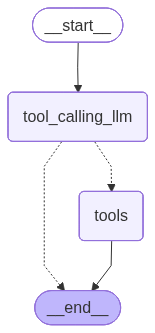

In [52]:
##Chatbot with LangGraph
from IPython.display import display, Image
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#define nodes
def tool_calling_llm(State:ChatStateSchema):
    return {"messages":[llm_with_tools.invoke(State["messages"])]}

#Build Graph

builder=StateGraph(ChatStateSchema)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition) #if the message from assistant contains tool calls then go to tools_condition else end
builder.add_edge("tools",END)
chatbot_graph=builder.compile()

#display graph
display(Image(chatbot_graph.get_graph().draw_mermaid_png()))



In [48]:
chatbot_graph.invoke({"messages": HumanMessage(content="What is Machine Learning")})

{'messages': [HumanMessage(content='What is Machine Learning', additional_kwargs={}, response_metadata={}, id='beb99225-0e45-4cae-a908-0f66232b83d5'),
  AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "What is Machine Learning?" I need to provide a clear and concise answer. Let me start by recalling the basics. Machine Learning is a subset of artificial intelligence that involves algorithms learning from data. But I should make sure I\'m accurate. Maybe I should check Wikipedia for a standard definition.\n\nWait, since the user is asking for a fundamental explanation, using the Wikipedia function makes sense. The arXiv function is more for research papers, which might be too advanced here. The Tavily Search could also be useful, but since the question is general, Wikipedia is probably sufficient.\n\nI should call the Wikipedia function with the query "Machine Learning". That should retrieve a reliable definition and overview. No need for any othe

In [53]:

messages = chatbot_graph.invoke({"messages": HumanMessage(content="What is Machine Learning")})

# Access the actual list of message objects inside the response
for m in messages["messages"]:
    m.pretty_print()


================================ Human Message =================================

What is Machine Learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (jeqrceqgt)
 Call ID: jeqrceqgt
  Args:
    query: Machine Learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filterin